**桂李超 2016210896 应用统计硕士**

In [14]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
df_raw = pd.read_csv(r"E:\07_data\00_practise\score_card\data.csv")

# 删除缺失变量过多的客户

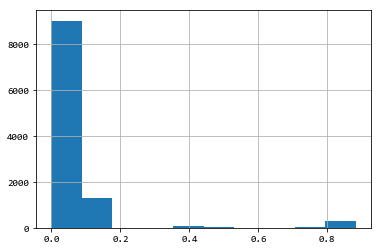

In [16]:
a = df_raw.isnull().sum(axis=1) / df_raw.shape[1]
a.hist()

- 可见多数客户的变量缺失比例在20%以下，这一部分可考虑进行缺失值填补，对于缺失比例大于20%的部分，因为缺失比例过大，没有填补的意义

In [19]:
df_raw1 = df_raw[a < 0.2].copy()

# 剔除缺失比例过多的变量

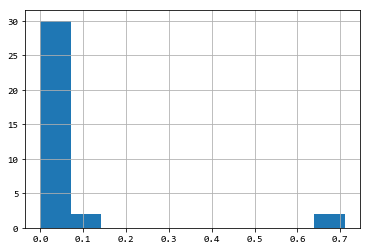

In [23]:
b = df_raw1.isnull().sum(axis=0) / df_raw1.shape[0]
b.hist()

- 可见大多数变量缺失比例在20%以内，将缺失比例超过20%的变量剔除

In [28]:
df_raw2 = df_raw1.loc[:, b[b < 0.2].index].copy()

- 综上，通过考察数据的缺失情况，剔除了424个无效样本和2个无效特征(var32和var33）

# 缺失值填补(中位数填补）

In [36]:
df_raw3 = df_raw2.fillna(df_raw2.median())

# 分类变量dummy
- var1是二分类变量 故需引入两个个虚拟变量 但只需放入一个即可 另一个作为基准


In [201]:
dummy = pd.get_dummies(df_raw3['var1'], prefix='is_VIP')
dummy.head()

,is_VIP_0.0,is_VIP_1.0
0,1,0
1,1,0
2,0,1
3,1,0
4,0,1


In [203]:
cols_to_keep = df_raw3.columns.tolist()
cols_to_keep.remove('var1')

In [226]:
df_raw4 = df_raw3[cols_to_keep].join(dummy.loc[:, 'is_VIP_1.0'])

# 数据集划分

In [227]:
from sklearn.model_selection import train_test_split
X = df_raw4.iloc[:, 1:]
y = df_raw4.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

# 建立逻辑回归模型

In [228]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight="balanced")
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

# 计算评价指标

In [61]:
from sklearn import metrics

In [229]:
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
y_train_pred_prob = lr.predict_proba(X_train)[:, 1]
y_test_pred_prob = lr.predict_proba(X_test)[:, 1]

## AUC值

In [87]:
print("在训练集上的AUC值：", metrics.roc_auc_score(y_score=y_train_pred_prob, y_true=y_train))
print("在测试集上的AUC值：",metrics.roc_auc_score(y_score=y_test_pred_prob, y_true=y_test))

在训练集上的AUC值： 0.6918897449596492
在测试集上的AUC值： 0.6192354227744428


## AR(Accuracy Ratio)

In [89]:
print("在训练集上的AR值：", metrics.accuracy_score(y_pred=y_train_pred, y_true=y_train))
print("在测试集上的AR值：",metrics.accuracy_score(y_pred=y_test_pred, y_true=y_test))

在训练集上的AR值： 0.6061831840508524
在测试集上的AR值： 0.6017595307917889


## KS值

In [127]:
from scipy.stats import ks_2samp
get_ks = lambda y_pred,y_true: ks_2samp(y_pred[y_true==1], y_pred[y_true!=1]).statistic
print("KS统计量值：", get_ks(y_test_pred_prob, y_test))

KS统计量值： 0.20543068546698307


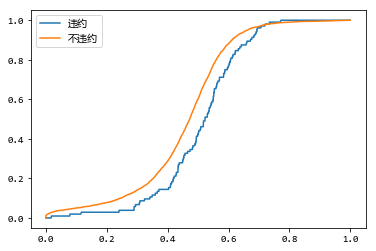

In [190]:
b = pd.DataFrame({'违约概率': y_test_pred_prob, '违约标记': y_test})
b['不违约标记'] = 1- b['违约标记']
c = b.sort_values(by=['违约概率', '违约标记'], ascending=[True, True])
c.index = range(len(c['违约概率']))
c['累计违约账户个数占比'] = c['违约标记'].cumsum() / c['违约标记'].sum()
c['累计不违约账户个数占比'] = c['不违约标记'].cumsum() / c['不违约标记'].sum()
plt.plot(c['违约概率'], c['累计违约账户个数占比'], label="违约")
plt.plot(c['违约概率'], c['累计不违约账户个数占比'], label="不违约")
plt.legend()

# 总结
- KS值 > 0.2,说明模型对于是否逾期具有一定的区分能力